In [1]:
%pip install keras_tuner
%pip install transformers

     |████████████████████████████████| 133 kB 7.7 MB/s 
     |████████████████████████████████| 3.8 MB 8.0 MB/s 
     |████████████████████████████████| 596 kB 88.1 MB/s 
     |████████████████████████████████| 895 kB 78.7 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 6.5 MB 89.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense, Dropout
from collections import Counter
from transformers import BertTokenizer
from transformers import TFAutoModel
from google.colab import files

In [14]:
# Load the two datasets into DataFrames
train_data = pd.read_csv("/content/sample_data/Corona_NLP_train.csv", encoding='latin-1')
test_data = pd.read_csv("/content/sample_data/Corona_NLP_test.csv", encoding='latin-1')

# Concatenate the two DataFrames
data = pd.concat([train_data, test_data])


# Remove irrelevant columns
data = data.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis=1)

# Create one hot vector representations of the labels and add them
# to the dataset
string_y = data['Sentiment']
sentiment_to_value = {"Extremely Negative": [1,0,0,0,0], "Negative": [0,1,0,0,0],
                      "Neutral": [0,0,1,0,0], "Positive": [0,0,0,1,0], 
                      "Extremely Positive": [0,0,0,0,1]}
oneHot=[]
for i in string_y:
    oneHot.append(sentiment_to_value[i])
data["OneHotLabel"] = oneHot

# Drop the original label column
data = data.drop(['Sentiment'],axis=1)
data

,OriginalTweet,OneHotLabel
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,"[0, 0, 1, 0, 0]"
1,advice Talk to your neighbours family to excha...,"[0, 0, 0, 1, 0]"
2,Coronavirus Australia: Woolworths to give elde...,"[0, 0, 0, 1, 0]"
3,My food stock is not the only one which is emp...,"[0, 0, 0, 1, 0]"
4,"Me, ready to go at supermarket during the #COV...","[1, 0, 0, 0, 0]"
...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,"[0, 0, 0, 1, 0]"
3794,Did you panic buy a lot of non-perishable item...,"[0, 1, 0, 0, 0]"
3795,Asst Prof of Economics @cconces was on @NBCPhi...,"[0, 0, 1, 0, 0]"
3796,Gov need to do somethings instead of biar je r...,"[1, 0, 0, 0, 0]"


In [15]:
# Set the sequence length to 48
seq_len = 48
num_samples = len(data)

# Create the initial Id and mask vectors
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))

# Create the tokenizer from the pretrained bert-base model
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Encode all of the phrases in the dataset and set the ids and mask accordingly
for i, phrase in enumerate(data["OriginalTweet"]):
    tokens = tokenizer.encode_plus(phrase, max_length=seq_len, truncation=True,
                                   padding='max_length', add_special_tokens=True,
                                   return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [16]:
# Cast the ids and masks as integer values
Xids = np.asarray(Xids).astype('int32')
Xmask = np.asarray(Xmask).astype('int32')
labels = list(data["OneHotLabel"].values)

# Create the dataset from the Id, mask, and label arrays
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

# Maps all elements of the dataset
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels
dataset = dataset.map(map_func)

# Set the batch size and shuffle the dataset
batch_size = 12
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

# Split into training, validation and testing sets
# Training = 70%, Validation = 15%, Testing = 15%
train_split = 0.7
val_split = 0.15

train_size = int((num_samples / batch_size) * train_split)
val_size = int((num_samples / batch_size) * val_split)
    
train_ds = dataset.take(train_size)    
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

In [17]:
# Load the bert-base-uncased model
bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [18]:
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

embeddings = bert.bert(input_ids, attention_mask=mask)[1]

x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dropout(0.4)(x)
z = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(y)

In [19]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=z)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 48)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 48)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 48,                                          

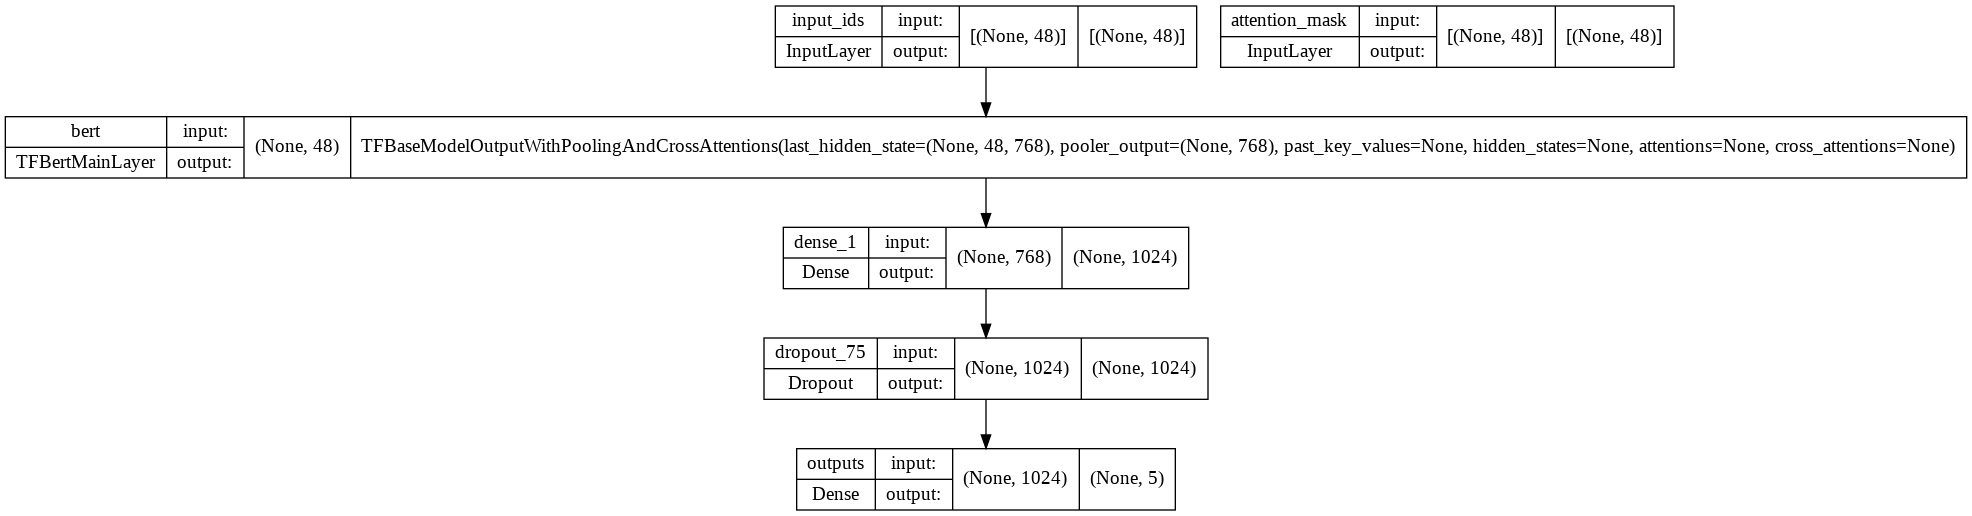

In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
accuracy = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[accuracy])

tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)
model.evaluate(test_ds)

# Graph the model's accuracy performance 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Graph the model's loss performance 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# !mkdir -p saved_model
# model.save('saved_model/my_model')
# !zip -r /content/file.zip /content/saved_model
# files.download("/content/file.zip")

Epoch 1/50
2622/2622 [==============================] - 251s 92ms/step - loss: 1.5280 - accuracy: 0.2949 - val_loss: 1.4190 - val_accuracy: 0.3660
Epoch 2/50
2622/2622 [==============================] - 241s 92ms/step - loss: 1.3194 - accuracy: 0.4268 - val_loss: 1.1721 - val_accuracy: 0.5150
Epoch 3/50
2622/2622 [==============================] - 241s 92ms/step - loss: 1.1320 - accuracy: 0.5291 - val_loss: 1.0037 - val_accuracy: 0.5922
Epoch 4/50
2622/2622 [==============================] - 241s 92ms/step - loss: 0.9660 - accuracy: 0.6130 - val_loss: 0.9599 - val_accuracy: 0.6280
Epoch 5/50
2622/2622 [==============================] - 241s 92ms/step - loss: 0.8252 - accuracy: 0.6775 - val_loss: 0.8457 - val_accuracy: 0.6736
Epoch 6/50
2622/2622 [==============================] - 241s 92ms/step - loss: 0.7117 - accuracy: 0.7276 - val_loss: 0.7460 - val_accuracy: 0.7302
Epoch 7/50
2622/2622 [==============================] - 241s 92ms/step - loss: 0.6078 - accuracy: 0.7715 - val_loss: 0

KeyboardInterrupt: ignored